In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('train.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [2]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [3]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n 전체 feature 들의 type \n', house_df.dtypes.value_counts())
isna_series = house_df.isna().sum()
print('\n Null 컬럼과 그 건수: \n',  isna_series[isna_series>0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)

 전체 feature 들의 type 
 object     43
int64      35
float64     3
dtype: int64

 Null 컬럼과 그 건수: 
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


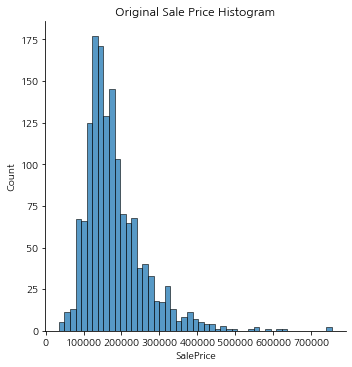

In [4]:
# 타겟값 분포도 확인
sns.displot(house_df['SalePrice'])
plt.title('Original Sale Price Histogram')
plt.show()

Text(0.5, 1.0, 'Log Transformed Sale Price Histogram')

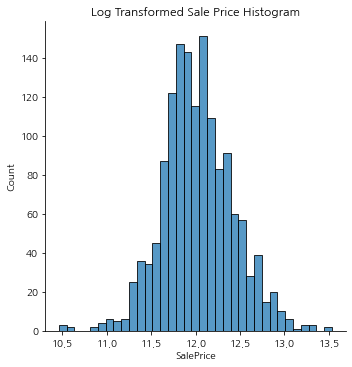

In [5]:
# 로그변환을 통해 SalePrice값 분포도 확인
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.displot(log_SalePrice)
plt.title('Log Transformed Sale Price Histogram')
# 타겟값이 정규분포처럼 나옴 good

In [6]:
# SalePrice로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null이 너무 많은 컬럼들과 불필요한 컬럼 삭제
house_df.drop(columns=['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)
# Drop하지 않는 숫자형 Null컬럼들은 평균값으로 대체
house_df.fillna(house_df.mean(), inplace=True)

# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isna().sum()[house_df.isna().sum() >0]
# dtypes[['','','']] 안에 있는 애들의 dtypes만 보여주기
print('## Null 피처의 Type: \n', house_df.dtypes[null_column_count.index])


## Null 피처의 Type: 
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [7]:
# 문자열값은 모두 카테고리값. 판다스의 get_dummies()를 이용하여 원-핫 인코딩 수행(null값들도 원핫인코딩댐)
print('get_dummies() 수행 전 데이터 shape', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 shape', house_df_ohe.shape)

null_column_count = house_df_ohe.isna().sum()[house_df_ohe.isna().sum() >0]
print('## Null 피처의 type: \n ', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 shape (1460, 75)
get_dummies() 수행 후 데이터 shape (1460, 271)
## Null 피처의 type: 
  Series([], dtype: object)


## 선형회귀 모델의 학습/예측/평가

##### RMSE 평가 함수 생성

In [8]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__, np.round(rmse,3)))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [9]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop(columns='SalePrice', axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train,y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train,y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.176


[0.13189576579154566, 0.12750846334053048, 0.17628250556471406]

In [10]:
def get_top_bottom_coef(model):
    coef = pd.Series(model.coef_ , index=X_features.columns)
    
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

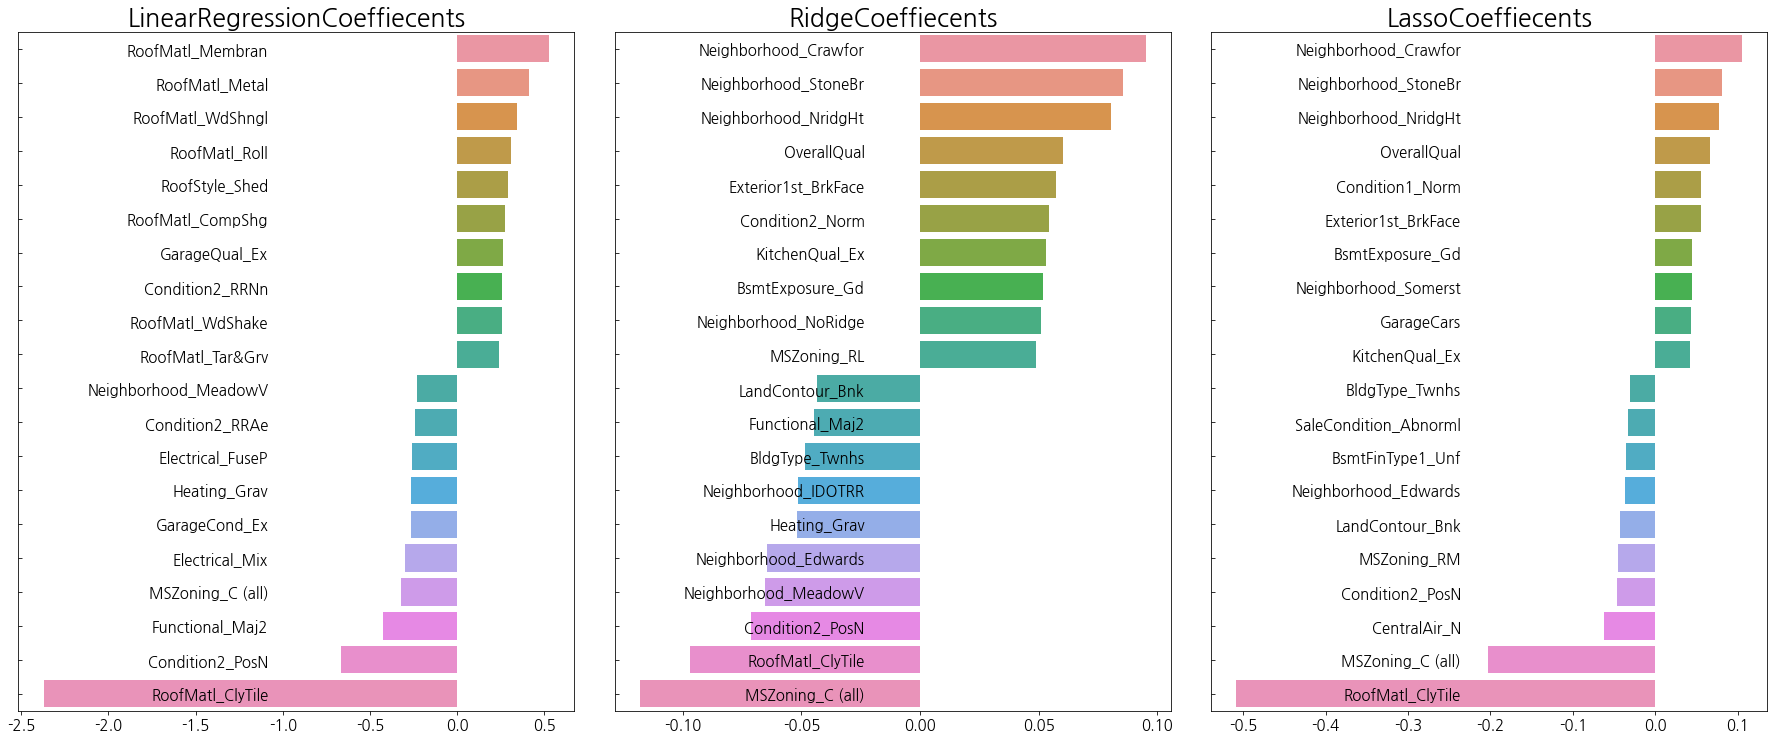

In [42]:
def visualize_coefficient(models):
    fig, axs = plt.subplots(figsize=(25,10), ncols=3, nrows=1)
    fig.tight_layout()
    for i_num, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])

        axs[i_num].set_title(model.__class__.__name__ + 'Coeffiecents', size=25)
        axs[i_num].tick_params(axis='y',pad= -250,direction='in')
        
        for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
            label.set_fontsize(15)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])
        
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [19]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score()수행
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring='neg_mean_squared_error',cv=5))
        rmse_avg = np.mean(rmse_list)
        print("\n {0} CV RMSE 값 리스트: {1}".format(model.__class__.__name__, np.round(rmse_list,3)))
        print(" {0} CV 평균 RMSE 값: {1}".format(model.__class__.__name__, np.round(rmse_avg,3)))

models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


 LinearRegression CV RMSE 값 리스트: [0.135 0.165 0.168 0.111 0.198]
 LinearRegression CV 평균 RMSE 값: 0.155

 Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
 Ridge CV 평균 RMSE 값: 0.144

 Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
 Lasso CV 평균 RMSE 값: 0.198


In [20]:
from sklearn.model_selection import GridSearchCV

def get_best_params(model, params):
        grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error',cv=5)
        grid_model.fit(X_features, y_target)
        rmse = np.sqrt(-1*grid_model.best_score_)
        print("{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha: {2}".format(model.__class__.__name__, np.round(rmse,4), grid_model.best_params_))
        
        return grid_model.best_estimator_


ridge_params = { 'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = { 'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
best_ridge = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1418, 최적 alpha: {'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.142, 최적 alpha: {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


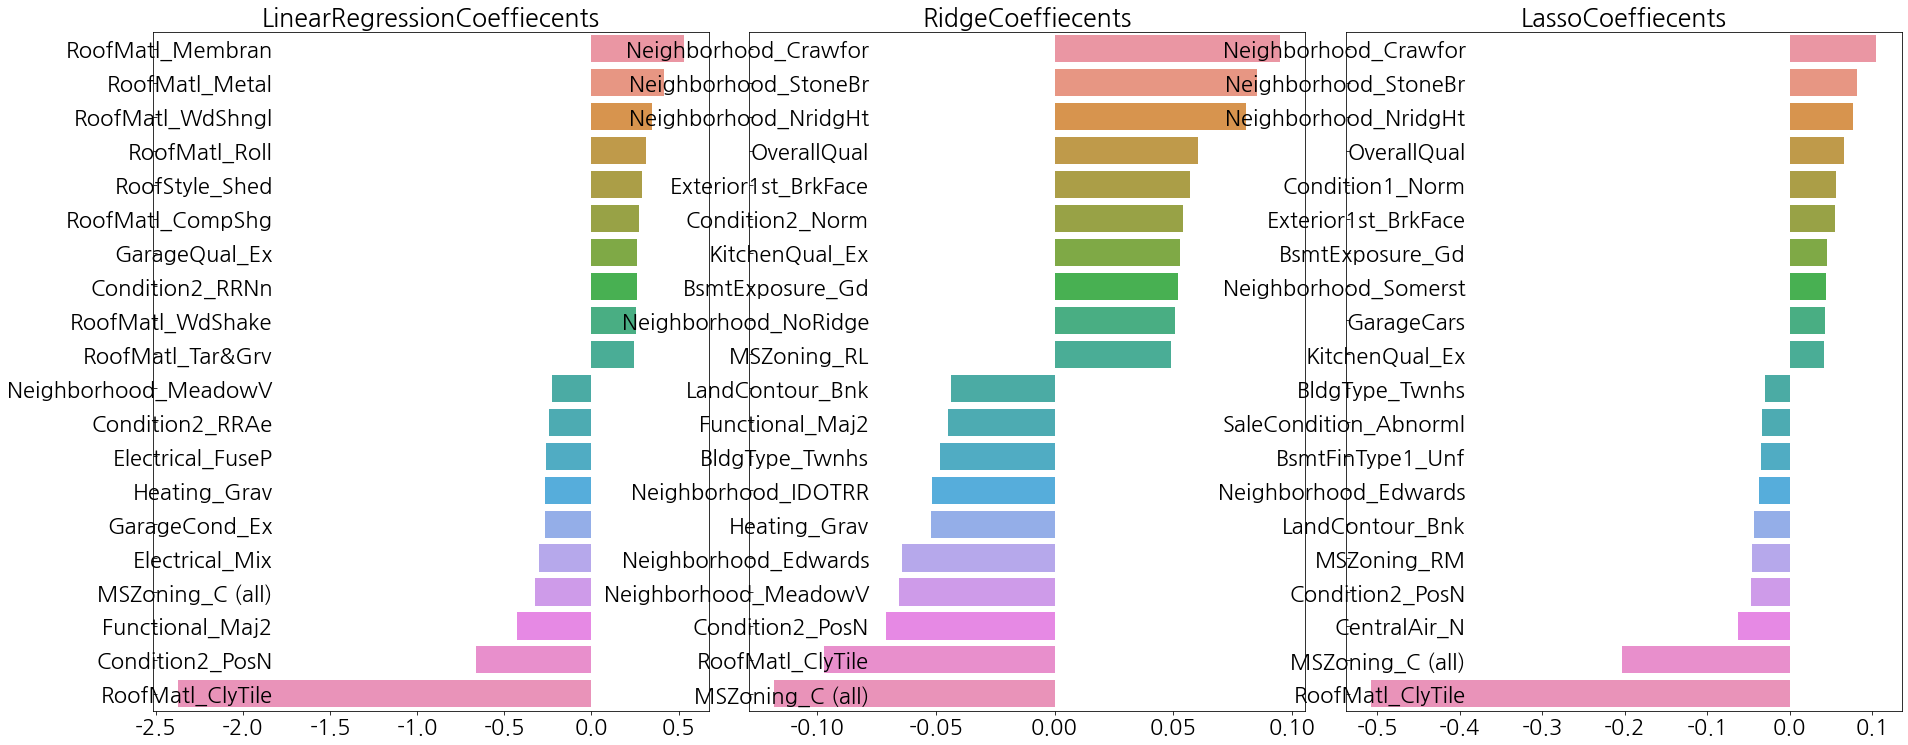

In [21]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [ ]:
from scipy